# Multi-step joining of monthly Sentinel-2 data with points of interest for training and application of a Random-Forst model

## 0. Introduction

This notebook demonstrates how to use the Geo Engine to process raster and vector data to to train an external Random-Forest model for field-use classification.
The generation of the training data is dnoe in the Geo Engine.
The model is trained using sklearn in this notebook.
Then, the model is applied to Sentinel-2 data queried from the Geo Engine.

### Use-Case

Spatial information of field-use is very important for various applications like yield estimation.
Using Earth Observation (EO) data we can generate large raster maps of crop type or field-use.
In this notebook, we want to generate such a map for an area in the state of North Rhine-Westphalia (NRW), Germany.
To generate such a map, we need ground truth data, e.g. sampling points where the real field-use is known.
Then, we can train a Maschine Learning (ML) modell on the sample points and the corresponding values of the EO data.
The trained model can then be applied to the whole area to generate a map of the field-use.

### Data

In this notebook, we use the following data:

#### EuroCrops (NRW, Germany)

As label data (ground truth) we use the EuroCrops data for NRW, Germany.
It is available under the [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/).
The data can be downloaded from [here](https://github.com/maja601/EuroCrops#vectordata_zenodo).
This dataset contains field polygons with different classes e.g. the crop type or the usage of the field.
For the demo presented in this notebook, we convert the field polygons into points and use them as sample-points.

#### Sentinel-2

The Sentinel-2 data we use is available from the Element 84 Sentinel-2 L2A Data Hub.
Using the STAC API, it can be queried for areas and times of interest.
The data is available under the [ESA Data License](https://sentinel.esa.int/documents/247904/690755/Sentinel_Data_Legal_Notice).
The Geo Engine provides an [ExternalDataProvider] that acts as a STAC API client that can be used to query the data.

### Workflow of this notebook

This notebook focuses on the extraction of the Sentinel-2 data for the points of interest and the model training :
1. Setup of packages, the Geo Engnie session and the area of interest.
2. Download the Sentinel-2 data for the area of interest and store it as a new (local) dataset.
3. Aggregate the Sentinel-2 data to cloud-free monthly means.
4. Attach the Sentinel-2 data to the points of interest.
5. Train a Random-Forest model to classify the field usage based on the Sentinel-2 data attached to the points.
6. Apply the model to Sentinel-2 data queried from the Geo Engine.


## 1. Setup


This notebook requires the following packages:

In [ ]:
from datetime import datetime
import asyncio
import geopandas as gpd
import geoengine as ge
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
from asyncstdlib.itertools import zip_longest
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier


Connect to the Geo Engine instance:

In [2]:
ge.initialize("http://localhost:3030/api", credentials=("admin@localhost", "admin1234"))

In [3]:
session = ge.get_session()
user_id = session.user_id
session

Server:              http://localhost:3030/api
User Id:             d5328854-6190-4af9-ad69-4e74b0961ac9
Session Id:          7988efae-f8e1-4165-a5bf-2a65ba32214f
Session valid until: 2023-04-16T10:50:58.406Z

Set the area of interest. It is defined as a bounding box in UTM 32 N (EPSG:32632).
It is locted in NRW, Germany and covers the area between Willingen, Lippstadt and Werl.

In [1]:
[xmin, ymin, xmax, ymax] = [421395,  5681078, 476201, 5727833]
(xmin, ymin, xmax, ymax)

(421395, 5681078, 476201, 5727833)

Using the bounding box, a time interval and a resolution, we define the area of interest as a temporal raster space-time cube.
The time interval is defined as a start and end date.
Since the field data is available for the year 2018, we use this year as the time interval.
The Sentinel-2 data has a resolution of 10 m, so we use this resolution for the area of interest as well.

In [5]:
time_start = datetime(2021, 1, 1)
time_end = datetime(2021, 12, 31)

study_area = ge.api.RasterQueryRectangle(
    spatialBounds=ge.SpatialPartition2D(xmin, ymin, xmax, ymax).to_api_dict(),
    timeInterval=ge.TimeInterval(time_start, time_end).to_api_dict(),
    spatialResolution=ge.SpatialResolution(10.0, 10.0).to_api_dict(),
)
study_area

{'spatialBounds': {'upperLeftCoordinate': {'x': 421395, 'y': 5727833},
  'lowerRightCoordinate': {'x': 476201, 'y': 5681078}},
 'timeInterval': {'start': '2021-01-01T00:00:00.000+00:00',
  'end': '2021-12-31T00:00:00.000+00:00'},
 'spatialResolution': {'x': 10.0, 'y': 10.0}}

## 2. Download Sentinel-2 data and store it in the Geo Engine

The Sentinel-2 data is stored in the cloud (AWS S3).
There is a STAC API that provides access to the data. 
To use the data in the Geo Engine, we create workflows that accesses the different Sentinel-2 bands and make them available.
This first kind of workflow only queries the data in the area of interest and stores it as local datasets.
This way, we don't need to download the data every time we use it.

For each band (B02, B03, B04, B08) as well as the scene mask (SCL), we create a workflow using the `sentinel2_band(band_name)` blueprint.
This convenience method creates a workflow that uses the [`GdalSource`](https://docs.geoengine.io/operators/gdalsource.html) to load the Sentinel-2 data.
A source operator like the `GdalSource` takes a `DatasetId` that identifies the data to load.
In this case, the `DatasetId` is provided by an external dataset provider, that resolves band "names" to the information how to load the data from STAC / S3.
Using the `save_as_dataset(study_area)` method, we tell the Geo Engine to store the data as a new dataset.
The new dataset gets a unique `DatasetId` that we can use to load the data in the next step.

In [6]:
download_tasks = {}

for b in ["B02", "B03", "B04", "B08", "SCL"]:
    sentinel2_band_workflow = ge.workflow_builder.blueprints.sentinel2_band(b)
    sentinel2_band_workflow_id = ge.register_workflow(sentinel2_band_workflow.to_workflow_dict())
    sentinel2_band_workflow_dataset_task = sentinel2_band_workflow_id.save_as_dataset(study_area, f"sentinel2_nrw_crop_10m_{b}")
    # We start the download task and turn it into a future. This way we can await all tasks at once.
    download_tasks[b] = sentinel2_band_workflow_dataset_task.as_future(print_status=False, update=60)

# the asyncio.gather function awaits all tasks at once and returns the final status as a list
download_task_results = await asyncio.gather(*download_tasks.values())

download_task_results

[TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 16, 9, 50, 58, 783000, tzinfo=datetime.timezone.utc),info = {'dataset': '81678f4d-00d1-4ed5-9bfa-947fb01fde48', 'upload': '6d47f3f3-14d8-4876-bd9c-161cf161ebbd'}, time_total = '05:19:17'),
 TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 16, 9, 50, 58, 788000, tzinfo=datetime.timezone.utc),info = {'dataset': '32db057a-fe32-4bb6-8389-22e1c7cd3416', 'upload': '69251b53-66a4-4fec-bd0d-2a1cfba5290b'}, time_total = '05:17:43'),
 TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 16, 9, 50, 58, 792000, tzinfo=datetime.timezone.utc),info = {'dataset': '287c227d-f806-49d5-a234-0729b3114b79', 'upload': '92c78453-d0b6-486b-9ff1-3d77c642a8d2'}, time_total = '05:18:24'),
 TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 16, 9, 50, 58, 796000, tzinfo=datetime.timezone.utc),info = {'dataset': '9abe9478-2528-4267-bb97-d5d1caec8c1c', 'upload': '6e36ee

In [7]:
# convert the list of results into a dictionary with the band name as key
download_status = {band: task_result for band, task_result in zip(download_tasks.keys(), download_task_results)}
download_status

{'B02': TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 16, 9, 50, 58, 783000, tzinfo=datetime.timezone.utc),info = {'dataset': '81678f4d-00d1-4ed5-9bfa-947fb01fde48', 'upload': '6d47f3f3-14d8-4876-bd9c-161cf161ebbd'}, time_total = '05:19:17'),
 'B03': TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 16, 9, 50, 58, 788000, tzinfo=datetime.timezone.utc),info = {'dataset': '32db057a-fe32-4bb6-8389-22e1c7cd3416', 'upload': '69251b53-66a4-4fec-bd0d-2a1cfba5290b'}, time_total = '05:17:43'),
 'B04': TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 16, 9, 50, 58, 792000, tzinfo=datetime.timezone.utc),info = {'dataset': '287c227d-f806-49d5-a234-0729b3114b79', 'upload': '92c78453-d0b6-486b-9ff1-3d77c642a8d2'}, time_total = '05:18:24'),
 'B08': TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 16, 9, 50, 58, 796000, tzinfo=datetime.timezone.utc),info = {'dataset': '9abe9478-2528-4267-bb97-d5d1

## 3. Monthly, cloud-free aggregations of the Sentinel-2 bands & NDVI

For the training, we use the Sentinel-2 data of the bands 02, 03, 04, and 08. The scene classification layer (SCL) is used to filter out cloudy pixels for each band using an expression. The NDVI is calculated using an expression on band 4 and 8. 


Using the bands dataset_ids, we create a map from band name to Geo Engine "InternalDataId". The "InternalDataId" is used to reference the datasets in the workflow.

In [8]:
## IF you ran the workflow, you can get the ids from the status
band_data_map = { name: task_status.info['dataset'] for name, task_status in download_status.items() }
## IF you have the data already added to the Geo Engine, e.g. by a previous run, you can also define the ids.
#band_data_map = {
# 'B02': 'a0630d89-fe7d-4087-98e4-aa496e681d50',
# 'B03': '1cfd9d51-6cbf-4490-9ce6-da224a6f5a83',
# 'B04': '6441f1f3-a9fb-4298-9161-eab91f0825e2',
# 'B08': '66479fef-4295-48f1-99bf-670f6b7ea540',
# 'SCL': '4d243f03-f59b-4298-80e9-0fb5aa94926e'
#}

band_data_id_map = {name: 
    ge.api.InternalDataId(
        type="internal",
        datasetId=dataset_id) for name, dataset_id in band_data_map.items()
} 

band_data_id_map

{'B02': {'type': 'internal',
  'datasetId': '81678f4d-00d1-4ed5-9bfa-947fb01fde48'},
 'B03': {'type': 'internal',
  'datasetId': '32db057a-fe32-4bb6-8389-22e1c7cd3416'},
 'B04': {'type': 'internal',
  'datasetId': '287c227d-f806-49d5-a234-0729b3114b79'},
 'B08': {'type': 'internal',
  'datasetId': '9abe9478-2528-4267-bb97-d5d1caec8c1c'},
 'SCL': {'type': 'internal',
  'datasetId': 'baa61a5e-ac5b-44c9-b1fe-8992d85f2748'}}

Now for each variable we want to use in the training, we create a workflow that aggregates the data to monthly, cloud-free means.
The workflow is created using the `s2_cloud_free_aggregated_band_custom_input` blueprint.
This blueprint takes the `DatasetId` of a band as well as the `DatasetId` of the scene classification layer (SCL) as input.
Then a workflow is created that uses the [`GdalSource`](https://docs.geoengine.io/operators/gdalsource.html) to load both rasters and an [`Expression`](https://docs.geoengine.io/operators/expression.html) to filter out pixels that are marked "cloudy" in the SCL.
The, now cloud-free, data is aggregated to monthly means using the [`TemporalRasterAggregation`](https://docs.geoengine.io/operators/temporalrasteraggregation.html) operator.

The NDVI is calculated using an expression on band 4 and 8.
For convenience, there is a `s2_cloud_free_aggregated_ndvi_custom_input` blueprint that takes the `DatasetId` of the bands 4, 8, and the SCL as input.
It creates a workflow that calculates the NDVI using an expression and then aggregates the data to monthly means.

In [9]:
agg_tasks = {}

for b in ["B02", "B03", "B04", "B08"]:
    sentinel2_band_workflow = ge.workflow_builder.blueprints.s2_cloud_free_aggregated_band_custom_input(band_id=band_data_id_map[b], scl_id=band_data_id_map["SCL"], granularity="months", window_size=1, aggregation_type="mean")
    sentinel2_band_workflow_id = ge.register_workflow(sentinel2_band_workflow.to_workflow_dict())
    agg_tasks[b] = sentinel2_band_workflow_id.save_as_dataset(study_area, f"sentinel2_nrw_crop_10m_cf_monthly_{b}").as_future(update=10)

ndvi_workflow = ge.workflow_builder.blueprints.s2_cloud_free_aggregated_ndvi_custom_input(nir_dataset=band_data_id_map["B08"], red_dataset=band_data_id_map["B04"], scl_dataset=band_data_id_map["SCL"], granularity="months", window_size=1, aggregation_type="mean")
ndvi_workflow_id = ge.register_workflow(ndvi_workflow.to_workflow_dict())
agg_tasks["NDVI"] = ndvi_workflow_id.save_as_dataset(study_area, f"sentinel2_nrw_crop_10m_cf_monthly_NDVI").as_future(request_interval=10)

# the asyncio.gather function awaits all tasks at once and returns the final status as a list
agg_task_results = await asyncio.gather(*agg_tasks.values())

agg_task_results

[TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 16, 15, 12, 13, 521000, tzinfo=datetime.timezone.utc),info = {'dataset': '0346ed60-8e44-4ec2-8d75-c0627b427581', 'upload': 'bfb6f0b6-94a4-4f3b-8045-26db1dc000cf'}, time_total = '00:07:55'),
 TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 16, 15, 12, 13, 527000, tzinfo=datetime.timezone.utc),info = {'dataset': '9130afe4-1cc9-4991-9d4b-b62db7328946', 'upload': '51cfc18c-b1ab-4913-a0c8-f8ae63c394e0'}, time_total = '00:08:01'),
 TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 16, 15, 12, 13, 532000, tzinfo=datetime.timezone.utc),info = {'dataset': '0d71d933-7b1f-467c-becf-408bf9cad8dd', 'upload': 'de1fceb4-a8da-48a2-a298-1f0773612807'}, time_total = '00:07:57'),
 TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 16, 15, 12, 13, 537000, tzinfo=datetime.timezone.utc),info = {'dataset': 'a9e3ec15-313c-48e8-b878-bbbb3f6b26ad', 'upload': '68

In [10]:
# convert the list of results into a dictionary with the band name as key
agg_status = {band: task_result for band, task_result in zip(agg_tasks.keys(), agg_task_results)}
agg_status

{'B02': TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 16, 15, 12, 13, 521000, tzinfo=datetime.timezone.utc),info = {'dataset': '0346ed60-8e44-4ec2-8d75-c0627b427581', 'upload': 'bfb6f0b6-94a4-4f3b-8045-26db1dc000cf'}, time_total = '00:07:55'),
 'B03': TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 16, 15, 12, 13, 527000, tzinfo=datetime.timezone.utc),info = {'dataset': '9130afe4-1cc9-4991-9d4b-b62db7328946', 'upload': '51cfc18c-b1ab-4913-a0c8-f8ae63c394e0'}, time_total = '00:08:01'),
 'B04': TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 16, 15, 12, 13, 532000, tzinfo=datetime.timezone.utc),info = {'dataset': '0d71d933-7b1f-467c-becf-408bf9cad8dd', 'upload': 'de1fceb4-a8da-48a2-a298-1f0773612807'}, time_total = '00:07:57'),
 'B08': TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 16, 15, 12, 13, 537000, tzinfo=datetime.timezone.utc),info = {'dataset': 'a9e3ec15-313c-48e8-b878-

## 4. Join the monthly Sentinel-2 data to the points of interest

This step combines the monthly Sentinel-2 data with the points of interest. The resulting dataset is then queried from directly from python and stored as a pandas dataframe.

Again, we create a map from band name to Geo Engine "InternalDataId" for the aggregated bands. The "InternalDataId" is used to reference the datasets in the workflow.

In [11]:
## IF you ran the aggregation workflow, you can get the ids from the status
monthly_band_data_map = { name: task_status.info['dataset'] for name, task_status in agg_status.items() }
## IF you have the data already added to the Geo Engine, e.g. by a previous run, you can also define the ids.
#monthly_band_data_map = {
#    'B02': '6aea7c86-05a6-45fc-ab3f-cd1020a83026',
#    'B03': '732bcff7-41b2-47a9-9a43-bb5d66feb8fd',
#    'B04': '209ffd4e-d750-4d88-a68a-5c36d739eb75',
#    'B08': 'ba469628-1c48-4172-af01-6bc460690600',
#    'NDVI': 'a5fbef96-0de3-498e-9e38-ddaf3a9fe47a'
#    }

monthly_band_data_id_map = {name: 
    ge.api.InternalDataId(
        type="internal",
        datasetId=dataset_id) for name, dataset_id in monthly_band_data_map.items()
} 


Upload the points of interest to the Geo Engine. First we use GeoPandas to load the points of interest into a DataFrame. Then we use the `upload_dataframe` method to upload the points to the Geo Engine.

In [12]:
points_df = gpd.read_file("group_sample_frac1_inspireId_use_utm32n.gpkg")
points_id = ge.upload_dataframe(points_df, "group_sample_frac1_inspireId")
points_id

3c516829-8457-44da-b18e-f81459991d00

To use the points in a Geo Engine workflow, we define a [`OgrSource`](https://docs.geoengine.io/operators/ogrsource.html) operator and pass the id of the uploaded points to it.

In [13]:
points_source_operator = ge.workflow_builder.operators.OgrSource(str(points_id))
points_source_operator.to_workflow_dict()

{'type': 'Vector',
 'operator': {'type': 'OgrSource',
  'params': {'data': {'type': 'internal',
    'datasetId': '3c516829-8457-44da-b18e-f81459991d00'},
   'attributeProjection': None,
   'attributeFilters': None}}}

Now, we create a workflow that uses [`RasterVectorJoin`](https://docs.geoengine.io/operators/rastervectorjoin.html) operator to join Sentinel-2 data to the points. This operator creates a new column for each band and adds the value of the raster pixel that is closest to each point. The points are provided as input by the [`OgrSource`](https://docs.geoengine.io/operators/ogrsource.html). Additionally the [`RasterVectorJoin`](https://docs.geoengine.io/operators/rastervectorjoin.html) takes up to 8 raster inputs that are provided by the [`GdalSource`](https://docs.geoengine.io/operators/gdalsource.html) operator. Here we generate a [`GdalSource`](https://docs.geoengine.io/operators/gdalsource.html) for each aggregated band (and the NDVI).

In [14]:
points_with_s2_cloud_free = ge.workflow_builder.operators.RasterVectorJoin(
    raster_sources=[ge.workflow_builder.operators.GdalSource(x) for x in monthly_band_data_id_map.values() ],
    vector_source=points_source_operator, #projected_points,
    new_column_names=[x for x in monthly_band_data_id_map.keys()],
)

points_with_s2_cloud_free.to_workflow_dict()

{'type': 'Vector',
 'operator': {'type': 'RasterVectorJoin',
  'params': {'names': ['B02', 'B03', 'B04', 'B08', 'NDVI'],
   'temporalAggregation': 'none',
   'featureAggregation': 'mean'},
  'sources': {'vector': {'type': 'OgrSource',
    'params': {'data': {'type': 'internal',
      'datasetId': '3c516829-8457-44da-b18e-f81459991d00'},
     'attributeProjection': None,
     'attributeFilters': None}},
   'rasters': [{'type': 'GdalSource',
     'params': {'data': {'type': 'internal',
       'datasetId': '0346ed60-8e44-4ec2-8d75-c0627b427581'}}},
    {'type': 'GdalSource',
     'params': {'data': {'type': 'internal',
       'datasetId': '9130afe4-1cc9-4991-9d4b-b62db7328946'}}},
    {'type': 'GdalSource',
     'params': {'data': {'type': 'internal',
       'datasetId': '0d71d933-7b1f-467c-becf-408bf9cad8dd'}}},
    {'type': 'GdalSource',
     'params': {'data': {'type': 'internal',
       'datasetId': 'a9e3ec15-313c-48e8-b878-bbbb3f6b26ad'}}},
    {'type': 'GdalSource',
     'params': {

We want to train a Random-Forest on Sentinel-2 time-series.
This requires us to provide all values ot the timeseries for each point similar to a table that has a column for each value at each point in time.
We can archive this using the [`TimeShift`](https://docs.geoengine.io/operators/timeshift.html) operator.
This operator shifts the query time interval by a given amount of time.
This way we can create a workflow that queries all the months we are interested in and attaches them as new columns to the points.
So we create a chain of `RasterVectorJoin` operators where each `RasterVectorJoin`operator joins the raster values of a different month to the points.




In [15]:
points_with_s2_cloud_free_shift = points_with_s2_cloud_free

for month_delta in range(-8,0):
    points_with_s2_cloud_free_shift = ge.workflow_builder.operators.RasterVectorJoin(
    raster_sources=[ge.workflow_builder.operators.TimeShift(granularity="months", value=month_delta, shift_type="relative", source=ge.workflow_builder.operators.GdalSource(x)) for x in monthly_band_data_id_map.values() ],
    vector_source=points_with_s2_cloud_free_shift, #projected_points,
    new_column_names=[f'{x}_{month_delta}' for x in monthly_band_data_id_map.keys()],
)
       
points_with_s2_cloud_free_shift.to_workflow_dict()

{'type': 'Vector',
 'operator': {'type': 'RasterVectorJoin',
  'params': {'names': ['B02_-1', 'B03_-1', 'B04_-1', 'B08_-1', 'NDVI_-1'],
   'temporalAggregation': 'none',
   'featureAggregation': 'mean'},
  'sources': {'vector': {'type': 'RasterVectorJoin',
    'params': {'names': ['B02_-2', 'B03_-2', 'B04_-2', 'B08_-2', 'NDVI_-2'],
     'temporalAggregation': 'none',
     'featureAggregation': 'mean'},
    'sources': {'vector': {'type': 'RasterVectorJoin',
      'params': {'names': ['B02_-3', 'B03_-3', 'B04_-3', 'B08_-3', 'NDVI_-3'],
       'temporalAggregation': 'none',
       'featureAggregation': 'mean'},
      'sources': {'vector': {'type': 'RasterVectorJoin',
        'params': {'names': ['B02_-4',
          'B03_-4',
          'B04_-4',
          'B08_-4',
          'NDVI_-4'],
         'temporalAggregation': 'none',
         'featureAggregation': 'mean'},
        'sources': {'vector': {'type': 'RasterVectorJoin',
          'params': {'names': ['B02_-5',
            'B03_-5',
    

Now we can register the workflow at the Geo Engine and execute it:

In [16]:
workflow = ge.register_workflow(points_with_s2_cloud_free_shift.to_workflow_dict())
workflow

c16c9915-623c-5a59-a010-f35332412392

The `ResultDescriptor` of the workflow is a `VectorResultDescriptor`.
It includes the description of all the columns that are created by the workflow.

In [36]:
workflow.get_result_descriptor()

Data type:         MultiPoint
Spatial Reference: EPSG:32632
Columns:
  B03_-1:
    Column Type: int
    Measurement: unitless
  B08_-1:
    Column Type: int
    Measurement: unitless
  INSPIRE_ID:
    Column Type: text
    Measurement: unitless
  USE_TXT:
    Column Type: text
    Measurement: unitless
  ID:
    Column Type: int
    Measurement: unitless
  B04:
    Column Type: int
    Measurement: unitless
  B03_-6:
    Column Type: int
    Measurement: unitless
  B08_-6:
    Column Type: int
    Measurement: unitless
  B02_-4:
    Column Type: int
    Measurement: unitless
  B03_-4:
    Column Type: int
    Measurement: unitless
  B08_-5:
    Column Type: int
    Measurement: unitless
  B04_-8:
    Column Type: int
    Measurement: unitless
  B03_-2:
    Column Type: int
    Measurement: unitless
  NDVI_-5:
    Column Type: float
    Measurement: unitless
  B03_-5:
    Column Type: int
    Measurement: unitless
  B08_-2:
    Column Type: int
    Measurement: unitless
  NDVI_-1:
    C

To query the workflow we need datetime objects for the start and end of the time interval we are interested in.
Since the `TimeShift` operator takes care to generate 8 previous months, we need only need to query the last month of the time interval.

In [17]:
start_dt = datetime(2021, 10, 1, 0, 0, 0)
end_dt = datetime(2021, 10, 1, 0, 0, 0)

start_dt, end_dt

(datetime.datetime(2021, 10, 1, 0, 0), datetime.datetime(2021, 10, 1, 0, 0))

Now, we query the workflow that attaches the Sentinel-2 data for the area of interest.
We use a resolution of 10m, which is the native resolution if the Sentinel-2 bands.
The workflow result is transformed into a pandas dataframe automatically.

In [18]:
gp_res = await workflow.vector_stream_into_geopandas(
    ge.QueryRectangle(
        spatial_bounds=ge.BoundingBox2D(
            xmin=xmin,
            ymin=ymin,
            xmax=xmax,
            ymax=ymax,
        ),
        time_interval=ge.TimeInterval(
            start=start_dt,
            end=end_dt,
        ),
        resolution=ge.SpatialResolution(
            10.0,
            10.0,
        ),
        srs="EPSG:32632",
))

# gp_res.to_file("gp_res_10_frac1_monthly_use_utm32n_multi_steps_12months_shift.gpkg", driver="GPKG")
gp_res

,B04_-4,B04_-8,B08_-4,ID,NDVI_-8,USE_TXT,NDVI_-7,B03_-6,B08_-5,B08,...,B04,B02,B04_-7,B03_-3,B04_-6,B02_-6,NDVI_-1,geometry,time_start,time_end
0,670.0,580.0,4467.0,0,0.195496,Ölsaaten,0.263462,838.0,6426.0,1814.0,...,1166.0,607.0,490.0,923.0,606.0,548.0,0.085486,MULTIPOINT (428690.027 5711938.189),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
1,555.0,693.0,3485.0,1,0.204141,Getreide,0.321335,744.0,4763.0,3555.0,...,703.0,719.0,559.0,1279.0,523.0,627.0,0.134015,MULTIPOINT (427819.337 5710040.545),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
2,467.0,730.0,4042.0,2,0.198928,Getreide,0.333275,559.0,NaN,2369.0,...,1081.0,683.0,491.0,854.0,414.0,445.0,0.108832,MULTIPOINT (427320.866 5710158.178),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
3,247.0,183.0,2909.0,3,0.230494,Dauergrünland,0.126866,353.0,3174.0,1530.0,...,221.0,247.0,312.0,440.0,384.0,279.0,0.382076,MULTIPOINT (431527.388 5693772.886),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
4,387.0,893.0,4084.0,4,0.182051,Dauergrünland,0.179837,598.0,4572.0,3653.0,...,440.0,399.0,688.0,726.0,521.0,367.0,0.392298,MULTIPOINT (431535.193 5693614.690),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49419,431.0,787.0,4096.0,49419,0.171636,Getreide,0.150837,522.0,3499.0,2198.0,...,988.0,582.0,762.0,649.0,424.0,311.0,0.144446,MULTIPOINT (472357.075 5696612.529),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
49420,1462.0,802.0,2631.0,49420,0.107349,Getreide,0.094826,907.0,2597.0,4100.0,...,263.0,170.0,1704.0,598.0,1257.0,675.0,0.444122,MULTIPOINT (472016.875 5697690.039),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
49421,670.0,939.0,4567.0,49421,0.126312,Getreide,0.119380,856.0,4383.0,2392.0,...,875.0,506.0,1010.0,889.0,764.0,686.0,0.198792,MULTIPOINT (471981.413 5696219.338),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
49422,1414.0,835.0,2660.0,49422,0.124168,Ackerfutter,0.112736,867.0,1702.0,4200.0,...,368.0,278.0,1204.0,777.0,998.0,809.0,0.420167,MULTIPOINT (471704.064 5697043.769),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00


## 5. Train a Random-Forest on the monthly Sentinel-2 data and the NRW crop data

Now we can train a Random-Forest on the monthly Sentinel-2 data and the NRW crop data. We use the `sklearn` package for this. But first, we need to prepare the data.

First, replace the nan values with 0.
This is necessary since the sklearn RF does not support nan values.

In [19]:
gp_train_1=gp_res.replace(np.nan, 0)
gp_train_1

,B04_-4,B04_-8,B08_-4,ID,NDVI_-8,USE_TXT,NDVI_-7,B03_-6,B08_-5,B08,...,B04,B02,B04_-7,B03_-3,B04_-6,B02_-6,NDVI_-1,geometry,time_start,time_end
0,670.0,580.0,4467.0,0,0.195496,Ölsaaten,0.263462,838.0,6426.0,1814.0,...,1166.0,607.0,490.0,923.0,606.0,548.0,0.085486,MULTIPOINT (428690.027 5711938.189),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
1,555.0,693.0,3485.0,1,0.204141,Getreide,0.321335,744.0,4763.0,3555.0,...,703.0,719.0,559.0,1279.0,523.0,627.0,0.134015,MULTIPOINT (427819.337 5710040.545),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
2,467.0,730.0,4042.0,2,0.198928,Getreide,0.333275,559.0,0.0,2369.0,...,1081.0,683.0,491.0,854.0,414.0,445.0,0.108832,MULTIPOINT (427320.866 5710158.178),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
3,247.0,183.0,2909.0,3,0.230494,Dauergrünland,0.126866,353.0,3174.0,1530.0,...,221.0,247.0,312.0,440.0,384.0,279.0,0.382076,MULTIPOINT (431527.388 5693772.886),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
4,387.0,893.0,4084.0,4,0.182051,Dauergrünland,0.179837,598.0,4572.0,3653.0,...,440.0,399.0,688.0,726.0,521.0,367.0,0.392298,MULTIPOINT (431535.193 5693614.690),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49419,431.0,787.0,4096.0,49419,0.171636,Getreide,0.150837,522.0,3499.0,2198.0,...,988.0,582.0,762.0,649.0,424.0,311.0,0.144446,MULTIPOINT (472357.075 5696612.529),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
49420,1462.0,802.0,2631.0,49420,0.107349,Getreide,0.094826,907.0,2597.0,4100.0,...,263.0,170.0,1704.0,598.0,1257.0,675.0,0.444122,MULTIPOINT (472016.875 5697690.039),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
49421,670.0,939.0,4567.0,49421,0.126312,Getreide,0.119380,856.0,4383.0,2392.0,...,875.0,506.0,1010.0,889.0,764.0,686.0,0.198792,MULTIPOINT (471981.413 5696219.338),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
49422,1414.0,835.0,2660.0,49422,0.124168,Ackerfutter,0.112736,867.0,1702.0,4200.0,...,368.0,278.0,1204.0,777.0,998.0,809.0,0.420167,MULTIPOINT (471704.064 5697043.769),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00


Now we create the training input.
This also makes sure that the data is in the correct order when we train the RF.

In [20]:
train_variable_order = ['B02', 'B02_-1', 'B02_-2', 'B02_-3', 'B02_-4',  'B02_-5',  'B02_-6', 'B02_-7', 'B02_-8',
        'B03', 'B03_-1', 'B03_-2', 'B03_-3', 'B03_-4',  'B03_-5',  'B03_-6', 'B03_-7', 'B03_-8',
        'B04', 'B04_-1', 'B04_-2', 'B04_-3', 'B04_-4',  'B04_-5',  'B04_-6', 'B04_-7', 'B04_-8',
        'B08', 'B08_-1', 'B08_-2', 'B08_-3', 'B08_-4',  'B08_-5',  'B08_-6', 'B08_-7', 'B08_-8',
        'NDVI', 'NDVI_-1', 'NDVI_-2', 'NDVI_-3', 'NDVI_-4',  'NDVI_-5',  'NDVI_-6', 'NDVI_-7', 'NDVI_-8']

x_list = gp_train_1[train_variable_order].values

The labels are stored in the column `USE_CODE`. 

In [21]:
y_list = gp_train_1['USE_CODE'].replace(0, 'None')
y_list

0        OE
1        GT
2        GT
3        GL
4        GL
         ..
49419    GT
49420    GT
49421    GT
49422    AF
49423    GL
Name: USE_CODE, Length: 49424, dtype: object

First, we create a train-test split. We use 80% of the data for training and 20% for testing.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(x_list, y_list, test_size=0.2, random_state=31337, stratify=y_list)

Then, we train the RF on the training data:

In [33]:
X = X_train
Y = y_train
clf = RandomForestClassifier(random_state=1337, class_weight='balanced_subsample', n_estimators=300)
clf = clf.fit(X, Y)
str(clf)

"RandomForestClassifier(class_weight='balanced_subsample', n_estimators=300,\n                       random_state=1337)"

We can then create a report of the trained RF:

In [35]:
x_test_predictions = clf.predict(X_test)

print(classification_report(y_test, x_test_predictions, labels=clf.classes_, zero_division=0, digits=3))

              precision    recall  f1-score   support

          AF      0.655     0.671     0.663      1048
          DA      1.000     0.015     0.030        65
          EP      0.000     0.000     0.000        14
          EW      0.792     0.548     0.648       146
          GL      0.774     0.974     0.863      3919
          GM      0.500     0.154     0.235        39
          GT      0.833     0.879     0.855      2794
          HF      0.735     0.832     0.780       220
          HP      0.000     0.000     0.000         0
        None      0.000     0.000     0.000       108
          OE      0.878     0.859     0.868       284
          PA      0.000     0.000     0.000       238
          SF      0.857     0.038     0.074       156
          SL      0.611     0.202     0.303       847
          ZP      0.000     0.000     0.000         7

   micro avg      0.776     0.776     0.776      9885
   macro avg      0.509     0.345     0.355      9885
weighted avg      0.739   

Print the confusion matrix:

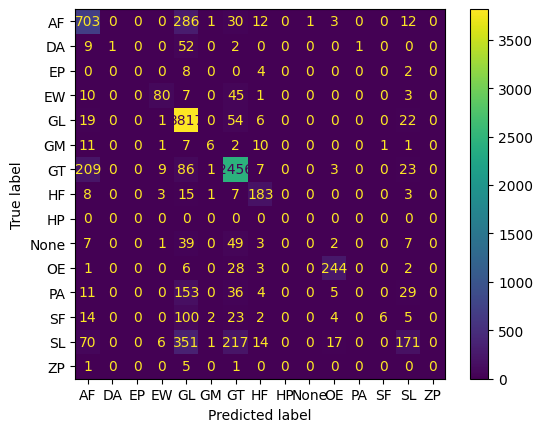

In [25]:
cm = confusion_matrix(y_test, clf.predict(X_test), labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot();

## 6. Apply the trained Random-Forest to the monthly Sentinel-2 data

We can now create a workflow that generates the same monthly Sentinel-2 data as before, but this time want to apply the trained RF to the data. To do this, we query raster tiles from the Geo Engine and apply the RF to each tile. The result is a new raster dataset that contains the predicted crop class for each pixel.

Create workflows that produce the monthly Sentinel-2 data as raster tiles:

In [26]:
band_workflows_a = {b: ge.workflow_builder.operators.GdalSource(x) for b, x in monthly_band_data_id_map.items()}

for month_delta in range(-8,0):
    for b in monthly_band_data_id_map.keys():
        w = band_workflows_a[b]
        band_workflows_a[f'{b}_{month_delta}'] = ge.workflow_builder.operators.TimeShift(granularity="months", value=month_delta, shift_type="relative", source=w)

len(band_workflows_a)

band_workflows_b = {b: ge.register_workflow(band_workflows_a[b].to_workflow_dict()) for b in train_variable_order }
band_workflows_b



{'B02': ff53c1aa-75f3-5bc5-8646-4b9ed83cebb2,
 'B02_-1': 8240d4ec-6d93-522f-b9ce-ff918ec4396f,
 'B02_-2': 3cd3520b-1467-53df-828c-addf95b77fb2,
 'B02_-3': 2cafb413-17bc-547d-abe9-3cfbabe08407,
 'B02_-4': e22906ed-ceef-54a8-801d-f88ebbdbf621,
 'B02_-5': 6e08143b-a457-514f-b0cd-679fb217bf89,
 'B02_-6': 3a7ff426-5be8-5da6-8da7-f5a9b42e6540,
 'B02_-7': 5de0d0b0-53be-5d01-abd7-bc2891bd445c,
 'B02_-8': 89797bf5-d4f4-5769-8dea-c0d7dfef6b4b,
 'B03': ca6aec44-566e-56b1-b8fd-b3ae460d0509,
 'B03_-1': bb8ca197-a10c-5b19-a4cc-98edd2e6d88f,
 'B03_-2': c9673a8a-279d-59c8-a9a8-9002692fd9a4,
 'B03_-3': e5177530-219b-58e0-aa20-f489e78388e8,
 'B03_-4': 0cd2af47-08d7-5b31-9298-1acc47fd44b0,
 'B03_-5': 3a8ce24b-56f9-5669-860a-4a7083a55045,
 'B03_-6': 26457fd6-e143-53f6-a605-1c47ad7f90c3,
 'B03_-7': 333449fa-476c-5b5d-bc33-f4f17a8b72aa,
 'B03_-8': 028b46b8-1040-596e-928c-e78c768f4944,
 'B04': 00049988-1888-50fa-a024-726e828374c6,
 'B04_-1': 3e7d36aa-5f65-5a8f-918a-dc6972904dac,
 'B04_-2': a58c5863-1946-5d40

Now we specify the query rectangle we are interested in. It is a subeset of the area of interest defined in step 2.

In [27]:
start_dt = datetime(2021, 10, 15, 0, 0, 0)
end_dt = datetime(2021, 10, 15, 0, 0, 0)

box_size = 512

box_center_x = 0.5 * (xmin + xmax)
box_center_y = 0.5 * (ymin + ymax)

box_x_min = box_center_x - box_size / 2
box_x_max = box_x_min + box_size
box_y_min = box_center_y - box_size / 2
box_y_max = box_y_min + box_size

query_rect = ge.QueryRectangle(
        spatial_bounds=ge.BoundingBox2D(
            xmin=box_x_min,
            ymin=box_y_min,
            xmax=box_x_max,
            ymax=box_y_max,
        ),
        time_interval=ge.TimeInterval(
            start=start_dt,
            end=end_dt,
        ),
        resolution=ge.SpatialResolution(
            10.0,
            10.0,
        ),
        srs="EPSG:32632",
)

query_rect

QueryRectangle( 
    BoundingBox2D(xmin=448542.0, ymin=5704199.5, xmax=449054.0, ymax=5704711.5)
    TimeInterval(start=2021-10-15 00:00:00+00:00, end=2021-10-15 00:00:00+00:00)
    SpatialResolution(x=10.0, y=10.0)
    srs=EPSG:32632 
)

We also need a map from category to number. This is necessary since the RF produces class names and we want to store the result as a raster dataset.

In [28]:
code_id_map = {
    'None': 0,
    'AF': 1,
    'DA': 2,
    'EP': 3,
    'EW': 4,
    'GL': 5,
    'GM': 6,
    'GT': 7,
    'HF': 8,
    'HP': 9,
    'OE': 10,
    'PA': 11,
    'SF': 12,
    'SL': 13,
    'ZP': 14,    
}

Now we query all the workflows in parallel and zip the results together. The result is a list of tiles, where each tile contains the monthly Sentinel-2 data for one band and month.
For each tile (list) we apply the RF to the data and store the result as a new tile. The result is a list of tiles, where each tile contains the predicted crop class for one pixel.

In [29]:
query_keys = list(band_workflows_b.keys())
queries = [
    w.raster_stream(query_rect) for w in band_workflows_b.values()
]

res_arrays = []

async for tile_stac in zip_longest(*queries):
    arr_stack = xr.concat(tile_stac, dim="band")
    arr_stack_2 = arr_stack.transpose("y", "x", "band")

    rf_input = arr_stack_2.values.reshape((box_size * box_size, len(tile_stac)))
  
    np.nan_to_num(rf_input, copy=False, nan=0, posinf=None, neginf=None)

    pred_classes = clf.predict(rf_input)
    pred_numbers = np.vectorize(code_id_map.get)(pred_classes)

    res_array = pred_numbers.reshape((box_size, box_size))
    
    da = xr.DataArray(
        data=res_array,
        dims=["y", "x"],
        coords=arr_stack_2.coords,
        attrs=dict(
            description="Predicted use."

        ),
    )      

    res_arrays.append(da)

We can now print the result as a image:

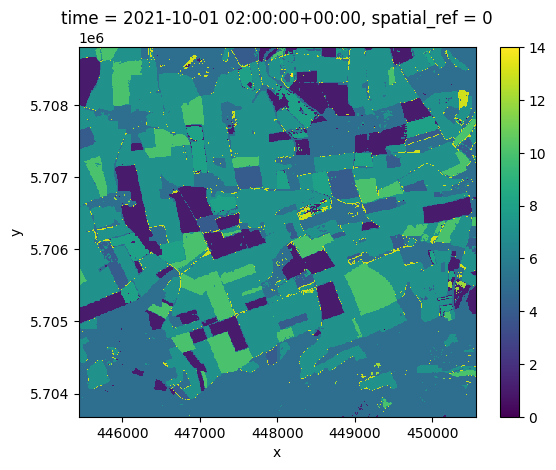

In [37]:
for arr in res_arrays:
    plt.figure()
    arr.plot();

And finally, we can store the result as a new GeoTiFF file:

In [31]:
for i, arr in enumerate(res_arrays):
    arr.rio.to_raster(
    f"arr_{i}.tif",
    tiled=True,  # GDAL: By default striped TIFF files are created. This option can be used to force creation of tiled TIFF files.
    windowed=True,  # rioxarray: read & write one window at a time
)